# Reward statistics

We import utils and libraries

In [1]:
import sys
from pathlib import Path

# Modify this as you wish, used for importing custom project packages, such as `utils`
project_path = str(Path.home()) + "\\Projects\\rlgym_demo"

sys.path.insert(0, project_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.analysis import plotting
from utils.analysis.reward_functions import common, custom
from rlgym.utils import common_values
import pandas as pd

Retrieve arena positions

In [3]:
arena_positions = plotting.arena_positions

## Dummy values generation

We use uniformly generated dummy values for ball positions, linear velocities and player forward vectors.

Those dummy values can be replaced in the future by values detected from replay data of various ranks.

### Grid-like arena positions

In [4]:
def generate_grid_positions(quarter_split=3, height=300):
    xs = np.linspace(common_values.SIDE_WALL_X,
                     -common_values.SIDE_WALL_X,
                     2 * quarter_split + 1)
    ys = np.linspace(common_values.BACK_WALL_Y,
                     -common_values.BACK_WALL_Y,
                     2 * quarter_split + 1)

    mesh_xs, mesh_ys = np.meshgrid(xs, ys)
    positions = np.stack([mesh_xs, mesh_ys], axis=-1).reshape(-1, 2)
    positions = np.hstack([positions, np.ones((positions.shape[0], 1)) * height])

    abs_positions = np.abs(positions)
    not_beyond_corner_condition = (abs_positions[:, 0] + abs_positions[:, 1] <
                                   common_values.SIDE_WALL_X + common_values.BACK_WALL_Y - 1152)
    return positions[not_beyond_corner_condition]

In [5]:
ball_positions = generate_grid_positions()

Positions that go beyond the arena corners are clipped

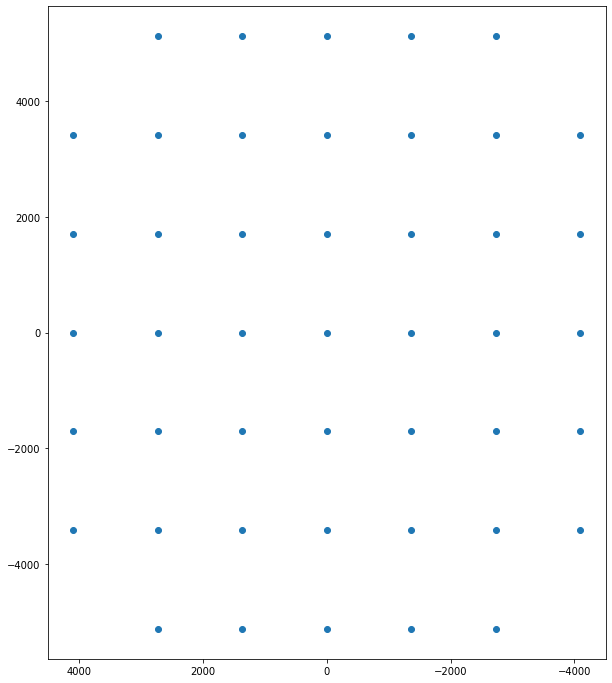

In [6]:
plt.figure(figsize=(10, 12))
plt.scatter(ball_positions[:, 0], ball_positions[:, 1])
plt.gca().invert_xaxis()
plt.show()

### Player linear velocities

All-point velocities of 1327.9 produce an L2 norm (velocity vector length \ speed) of 2300. 

2300 is the max player velocity.

In [7]:
player_velocities = np.repeat(np.linspace(1327.9, -1327.9, 100)[None], 3, 1).reshape(-1, 3)

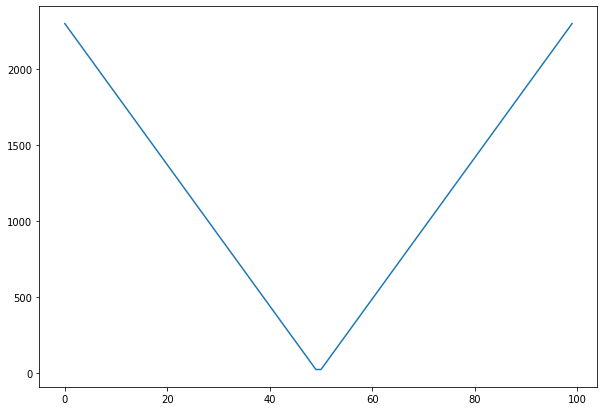

In [8]:
plt.figure(figsize=(10, 7))
plt.plot(np.linalg.norm(player_velocities, axis=1))
plt.show()

Generated player velocities decrease and increase linearly.

The mean is close to the true velocity mean 2300 / 2 = 1150.

In [9]:
np.linalg.norm(player_velocities, axis=1).mean()

1161.6112461468247

## Ball linear velocities

In [10]:
ball_velocities = np.repeat(np.linspace(3464.1, -3464.1, 100)[None], 3, 1).reshape(-1, 3)

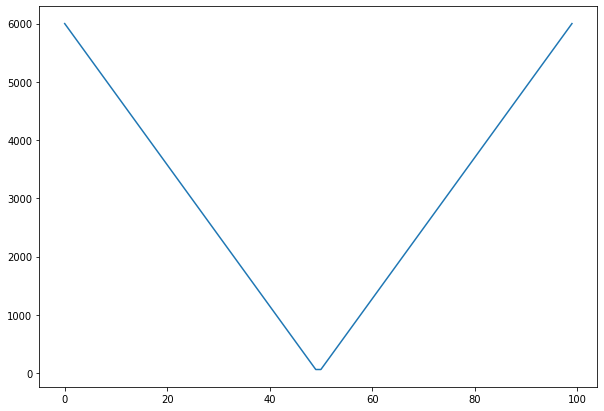

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(np.linalg.norm(ball_velocities, axis=1))
plt.show()

Generated ball velocities decrease and increase linearly.

The mean is close to the true velocity mean 6000 / 2 = 3000.

In [12]:
np.linalg.norm(ball_velocities, axis=1).mean()

3030.301617423913

### Player forward vectors

Player forward vectors can be thought of as 3-d point representations of a sphere with radius 1

In [13]:
def sphere_points(n_points=64):
    """
    Taken from 
    https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
    """
    indices = np.arange(0, n_points, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices / n_points)
    theta = np.pi * (1 + 5 ** 0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
    return np.stack([x, y, z], axis=-1)

In [14]:
forward_vectors = sphere_points()

In [15]:
forward_vectors.round(3)

array([[ 0.064, -0.164,  0.984],
       [-0.271,  0.134,  0.953],
       [ 0.372,  0.108,  0.922],
       [-0.236, -0.389,  0.891],
       [-0.099,  0.502,  0.859],
       [ 0.452, -0.332,  0.828],
       [-0.601, -0.065,  0.797],
       [ 0.425,  0.483,  0.766],
       [ 0.014, -0.679,  0.734],
       [-0.491,  0.514,  0.703],
       [ 0.739, -0.049,  0.672],
       [-0.6  , -0.48 ,  0.641],
       [ 0.122,  0.783,  0.609],
       [ 0.452, -0.679,  0.578],
       [-0.813,  0.201,  0.547],
       [ 0.752,  0.411,  0.516],
       [-0.283, -0.828,  0.484],
       [-0.357,  0.817,  0.453],
       [ 0.829, -0.367,  0.422],
       [-0.872, -0.294,  0.391],
       [ 0.451,  0.817,  0.359],
       [ 0.222, -0.918,  0.328],
       [-0.792,  0.533,  0.297],
       [ 0.953,  0.144,  0.266],
       [-0.611, -0.756,  0.234],
       [-0.061,  0.977,  0.203],
       [ 0.709, -0.684,  0.172],
       [-0.99 ,  0.025,  0.141],
       [ 0.75 ,  0.652,  0.109],
       [-0.112, -0.991,  0.078],
       [-0

Vector norms should be equal to 1

In [16]:
np.linalg.norm(forward_vectors, axis=-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

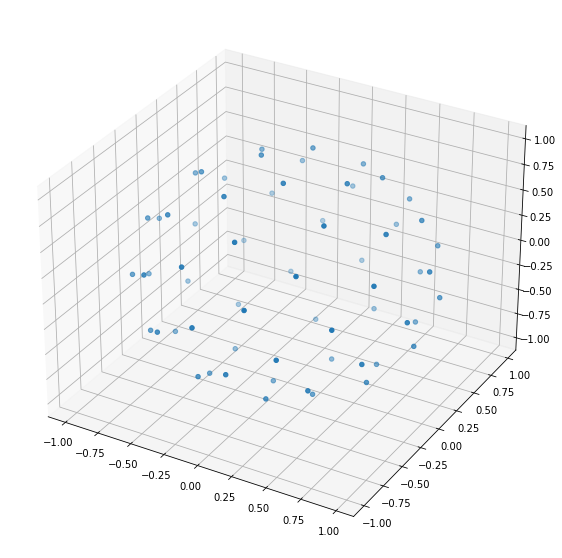

In [17]:
plt.figure(figsize=(10, 10))\
    .add_subplot(111, projection="3d")\
    .scatter(forward_vectors[:, 0], forward_vectors[:, 1], forward_vectors[:, 2])
plt.show()

## Common

### Align ball

In [18]:
align_ball_zs = [common.align_ball(arena_positions, ball_position, 0.5, 0.5)
                 for ball_position in ball_positions]

In [19]:
align_ball_mean_zs = np.array(align_ball_zs).mean(0)

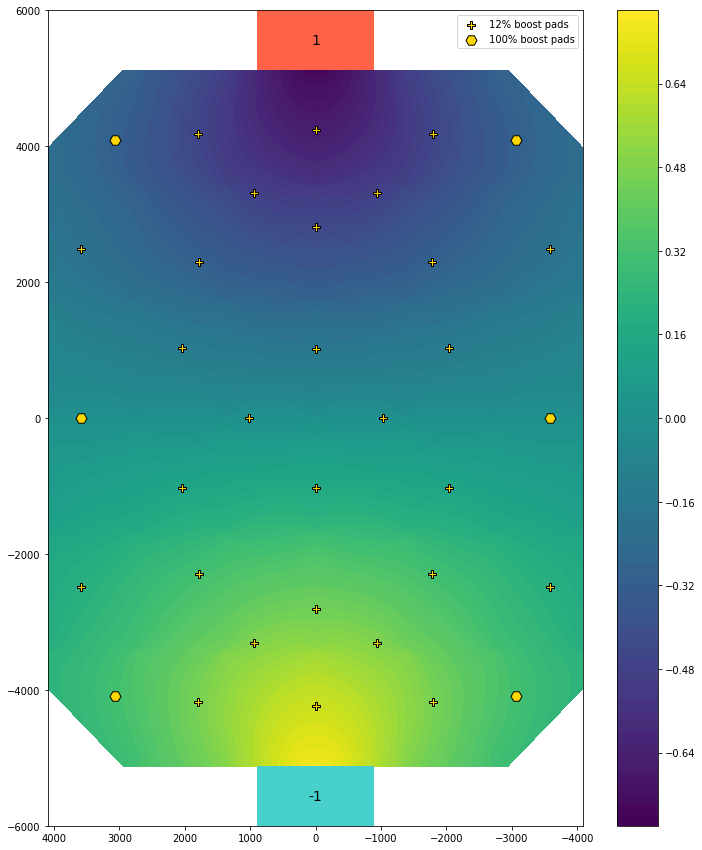

In [20]:
plotting.arena_contour(align_ball_mean_zs)

### Ball to goal distance

In [21]:
ball_y_coord_zs = common.ball_y_coord(arena_positions)

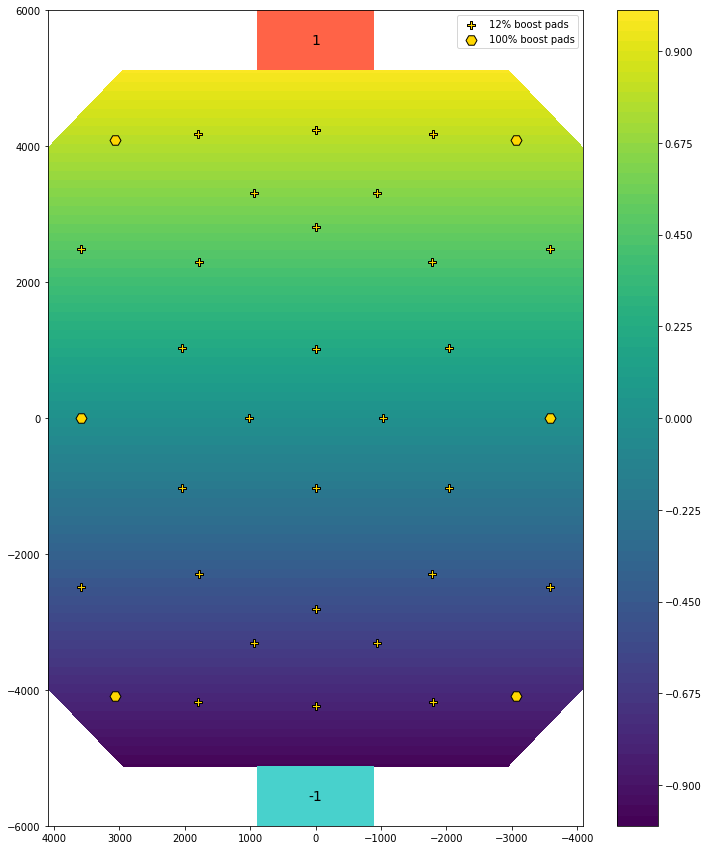

In [22]:
plotting.arena_contour(ball_y_coord_zs)

We skip conditionals, constants and events, since those cannot be visualized in the arena and do not directly help shape rewards.

### Face ball

In [23]:
face_ball_zs = np.array([common.face_ball(arena_positions, ball_position, forward_vec)
                         for ball_position in ball_positions for forward_vec in forward_vectors])

In [24]:
face_ball_mean_zs = face_ball_zs.mean(0)

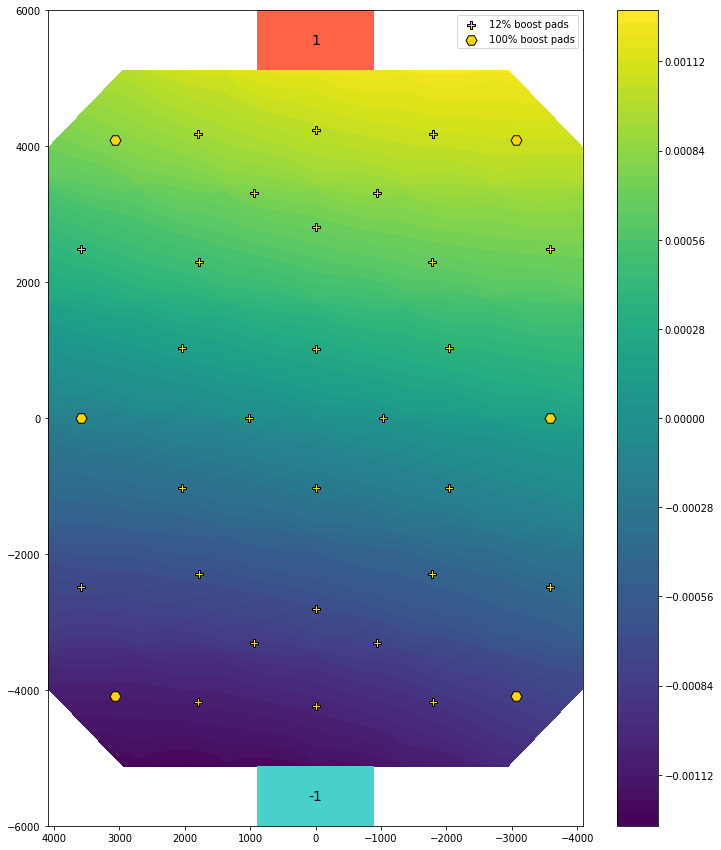

In [25]:
plotting.arena_contour(face_ball_mean_zs)

### Distance ball to goal

In [26]:
liu_dist_ball2goal_zs = common.liu_dist_ball2goal(arena_positions)

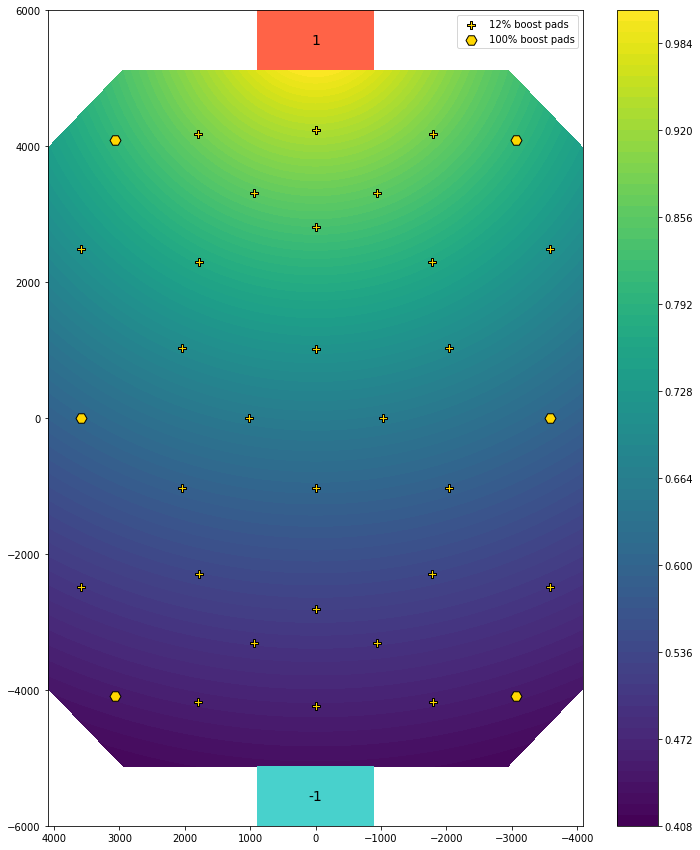

In [27]:
plotting.arena_contour(liu_dist_ball2goal_zs)

### Distance player to ball

In [28]:
liu_dist_player2ball_zs = np.array([common.liu_dist_player2ball(arena_positions, ball_position)
                                    for ball_position in ball_positions])

In [29]:
liu_dist_player2ball_mean_zs = liu_dist_player2ball_zs.mean(0)

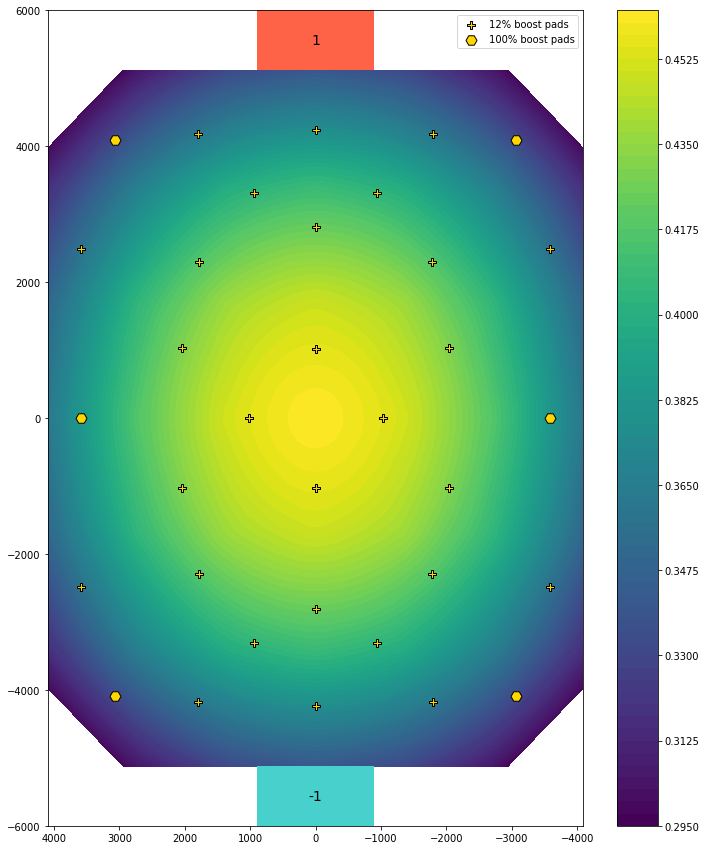

In [30]:
plotting.arena_contour(liu_dist_player2ball_mean_zs)

### Save boost

In [31]:
save_boost_zs = common.save_boost(np.linspace(0, 1, 40))

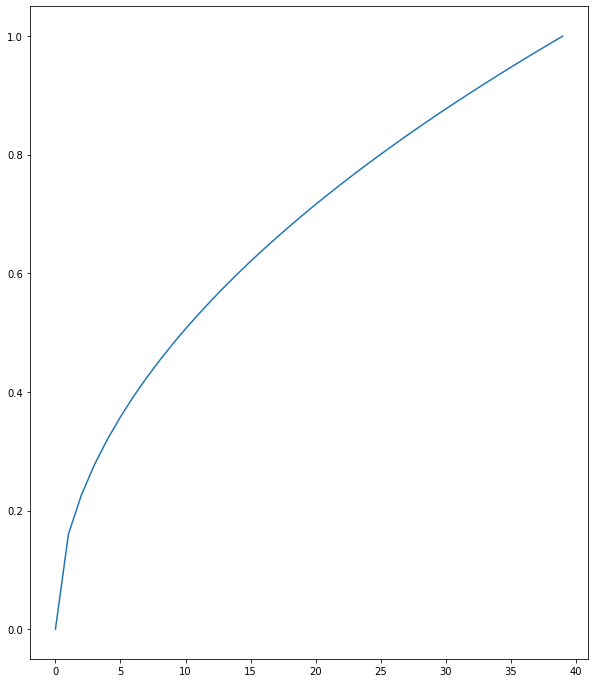

In [32]:
plt.figure(figsize=(10, 12))
plt.plot(save_boost_zs)
plt.show()

In [33]:
save_boost_series = pd.Series(save_boost_zs)

In [34]:
save_boost_series.describe()

count    40.000000
mean      0.661694
std       0.252496
min       0.000000
25%       0.499873
50%       0.707049
75%       0.866002
max       1.000000
dtype: float64

### Touch ball

In [35]:
ball_positions_aerial = np.zeros((40, 2))
ball_positions_aerial = np.hstack((ball_positions_aerial,
                                   np.linspace(0, common_values.CEILING_Z, 40)[:, None]))

In [36]:
touch_ball_zs = np.array([common.touch_ball(ball_position_aerial, 1)
                          for ball_position_aerial in ball_positions_aerial])

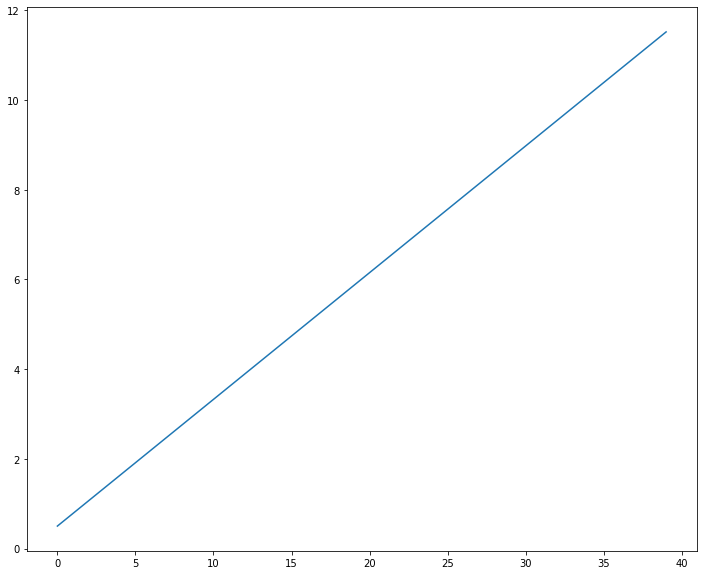

In [37]:
plt.figure(figsize=(12, 10))
plt.plot(touch_ball_zs);

In [38]:
touch_ball_series = pd.Series(touch_ball_zs)

In [39]:
touch_ball_series.describe()

count    40.000000
mean      6.009434
std       3.302963
min       0.500000
25%       3.254717
50%       6.009434
75%       8.764151
max      11.518868
dtype: float64

In [40]:
touch_ball_zs = np.array([common.touch_ball(ball_position_aerial, 2)
                          for ball_position_aerial in ball_positions_aerial])

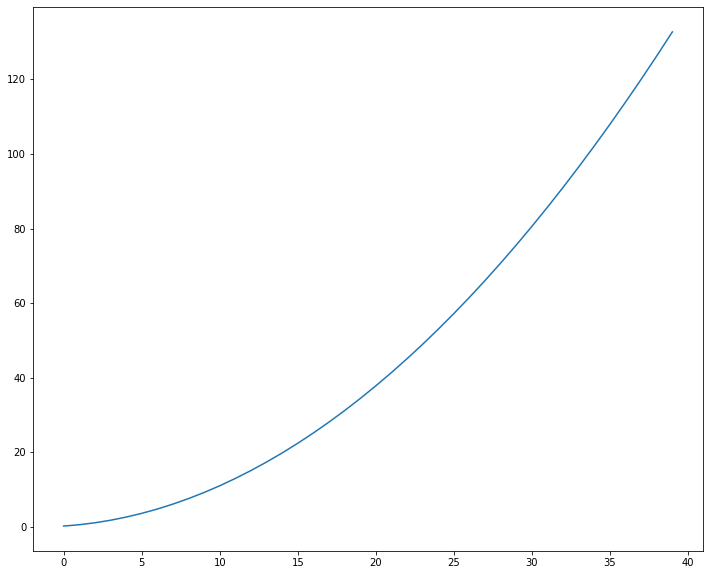

In [41]:
plt.figure(figsize=(12, 10))
plt.plot(touch_ball_zs);

In [42]:
touch_ball_series = pd.Series(touch_ball_zs)

In [43]:
touch_ball_series.describe()

count     40.000000
mean      46.750120
std       40.848273
min        0.250000
25%       10.608150
50%       36.133253
75%       76.825309
max      132.684318
dtype: float64

### Velocity

In [44]:
velocity_zs = common.velocity(player_velocities)

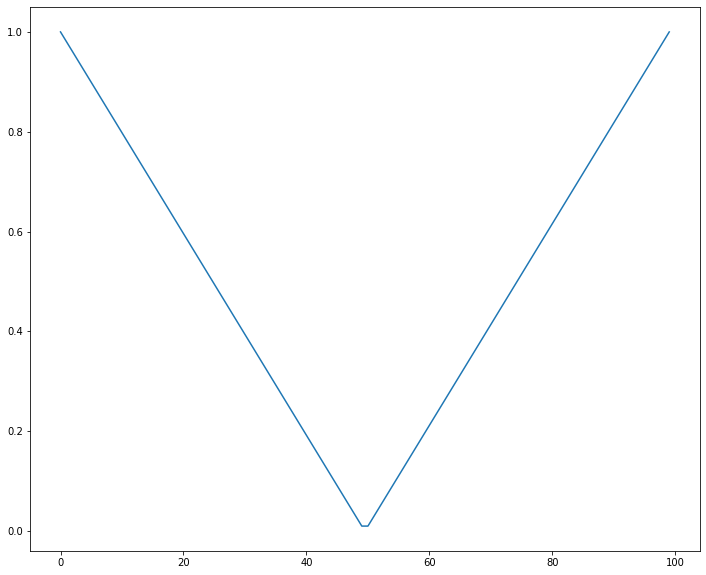

In [45]:
plt.figure(figsize=(12, 10))
plt.plot(velocity_zs);

In [46]:
pd.Series(velocity_zs).describe()

count    100.000000
mean       0.505048
std        0.293000
min        0.010101
25%        0.252524
50%        0.505048
75%        0.757573
max        0.999996
dtype: float64

### Velocity ball to goal

In [47]:
velocity_ball2goal_zs = np.array([common.velocity_ball2goal(arena_positions, ball_lin_velocity)
                                  for ball_lin_velocity in ball_velocities])

In [48]:
velocity_ball2goal_mean_zs = velocity_ball2goal_zs.mean(0)

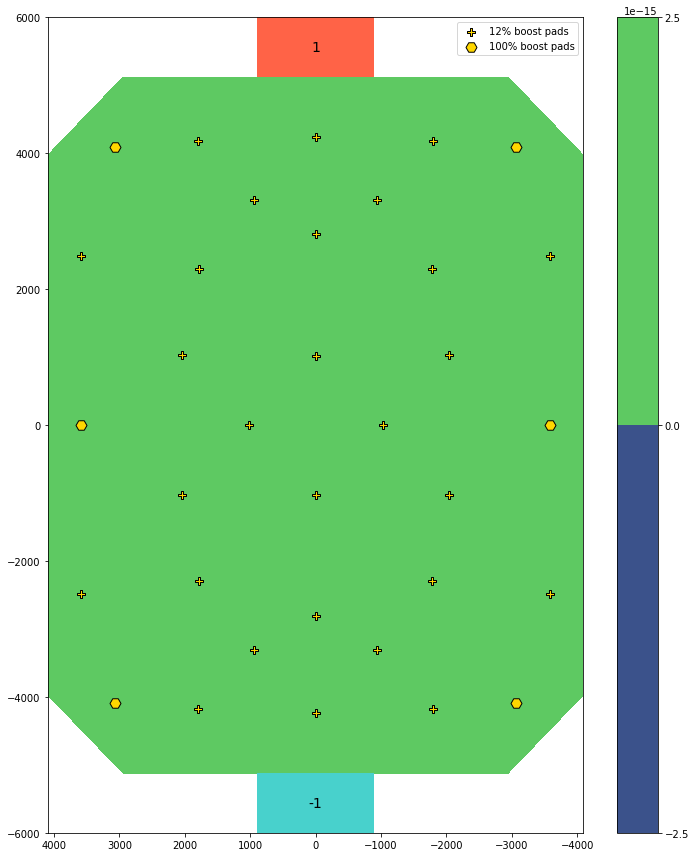

In [49]:
plotting.arena_contour(velocity_ball2goal_mean_zs.round(3))

### Velocity player to ball

In [50]:
velocity_player2ball_zs = np.array([common.velocity_player2ball(arena_positions,
                                                                ball_lin_velocity,
                                                                ball_position)
                                    for ball_lin_velocity in ball_velocities
                                    for ball_position in ball_positions])

In [51]:
velocity_player2ball_mean_zs = velocity_player2ball_zs.mean(0)

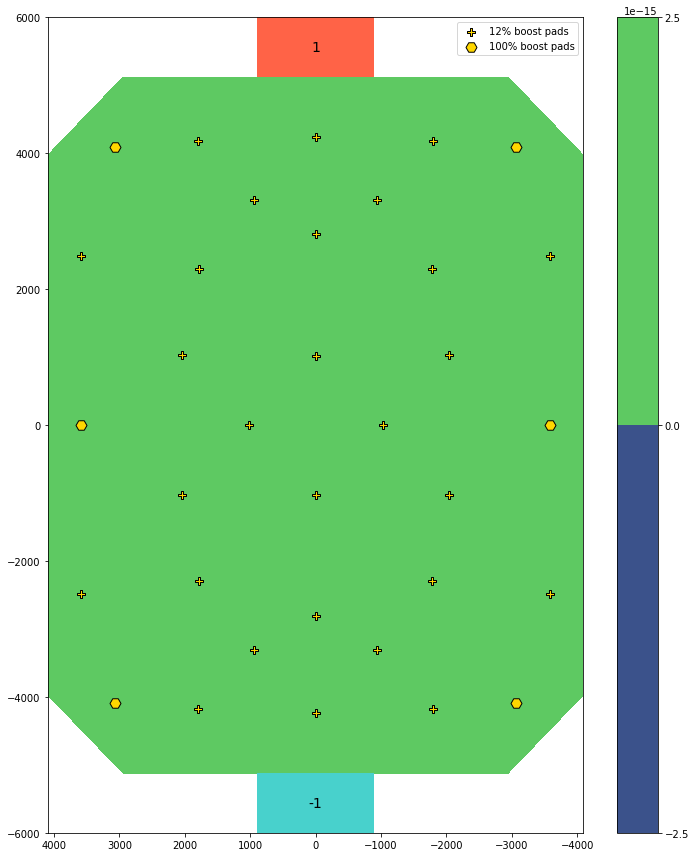

In [52]:
plotting.arena_contour(velocity_player2ball_mean_zs.round(3))

We skip extra rewards

## Custom

### Distance ball to goal wall

In [53]:
cust_ball_y_coord_zs = custom.ball_y_coord(arena_positions)

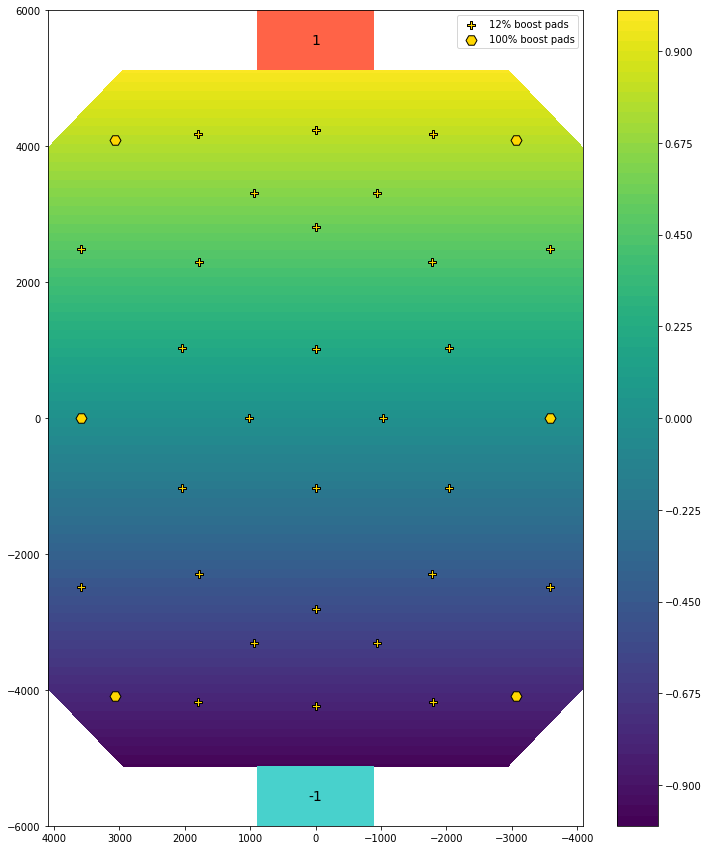

In [54]:
plotting.arena_contour(cust_ball_y_coord_zs)

In [55]:
cust_ball_y_coord_zs = custom.ball_y_coord(arena_positions, exponent=2)

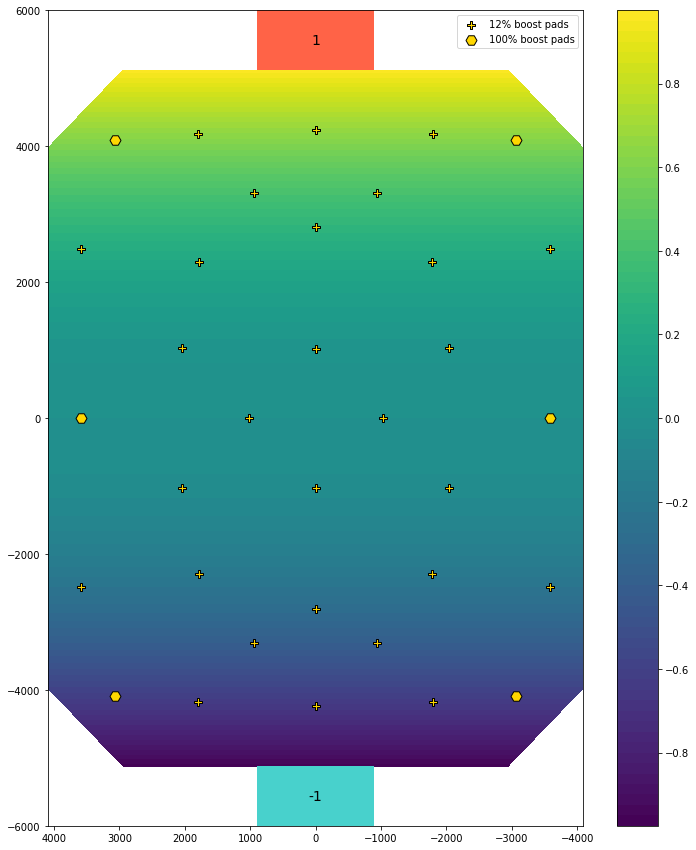

In [56]:
plotting.arena_contour(cust_ball_y_coord_zs)

### Distance player to ball

In [57]:
cust_liu_dist_player2ball_zs = np.array([custom.liu_dist_player2ball(arena_positions,
                                                                     ball_position,
                                                                     dispersion=1,
                                                                     density=1)
                                         for ball_position in ball_positions])

In [58]:
cust_liu_dist_player2ball__mean_zs = cust_liu_dist_player2ball_zs.mean(0)

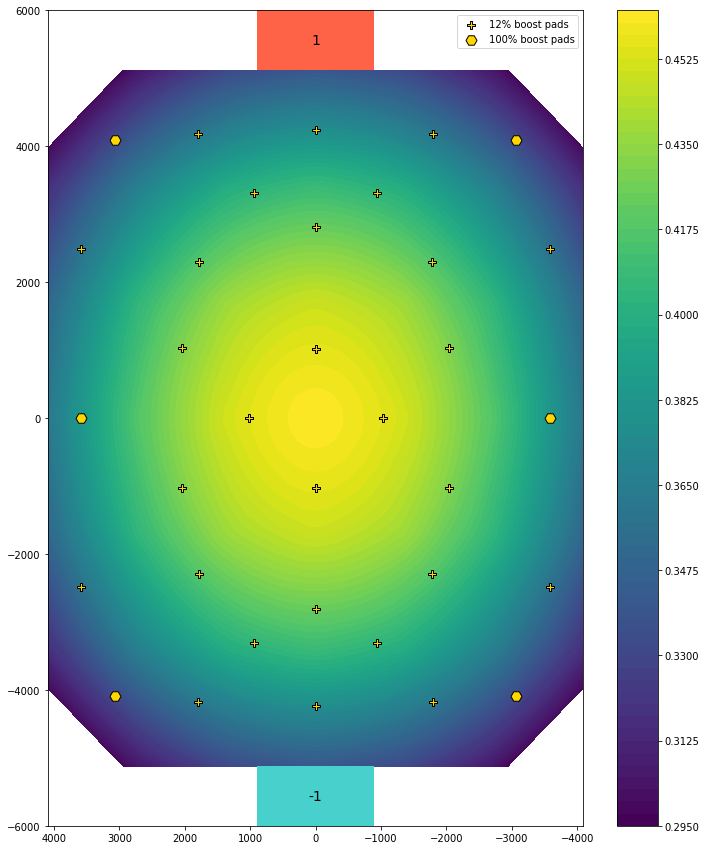

In [59]:
plotting.arena_contour(cust_liu_dist_player2ball__mean_zs)

In [60]:
cust_liu_dist_player2ball_zs = np.array([custom.liu_dist_player2ball(arena_positions,
                                                                     ball_position,
                                                                     dispersion=1.2,
                                                                     density=1)
                                         for ball_position in ball_positions])

In [61]:
cust_liu_dist_player2ball__mean_zs = cust_liu_dist_player2ball_zs.mean(0)

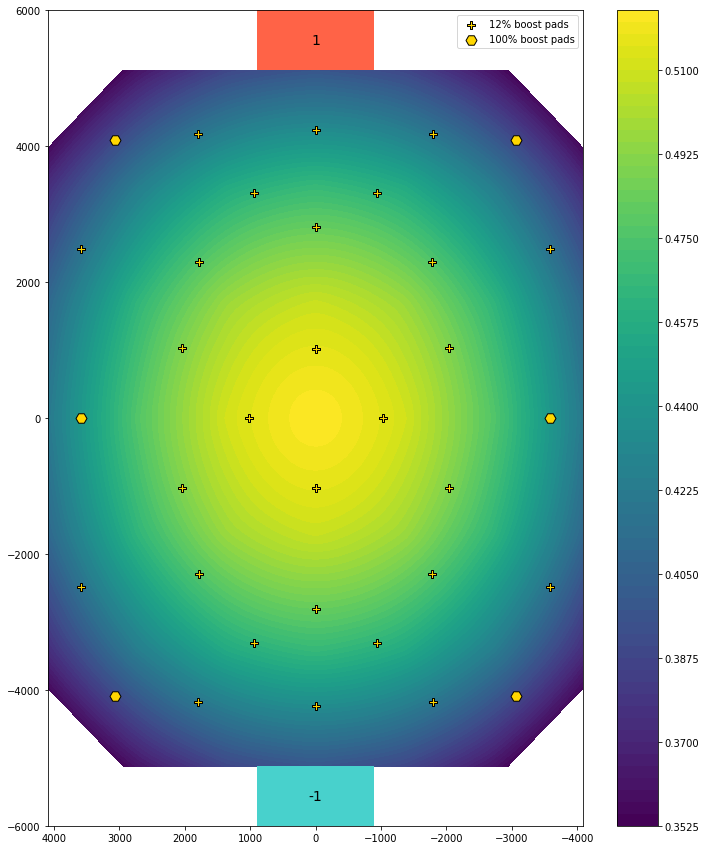

In [62]:
plotting.arena_contour(cust_liu_dist_player2ball__mean_zs)

In [63]:
cust_liu_dist_player2ball_zs = np.array([custom.liu_dist_player2ball(arena_positions,
                                                                     ball_position,
                                                                     dispersion=0.9,
                                                                     density=1.4)
                                         for ball_position in ball_positions])

In [64]:
cust_liu_dist_player2ball__mean_zs = cust_liu_dist_player2ball_zs.mean(0)

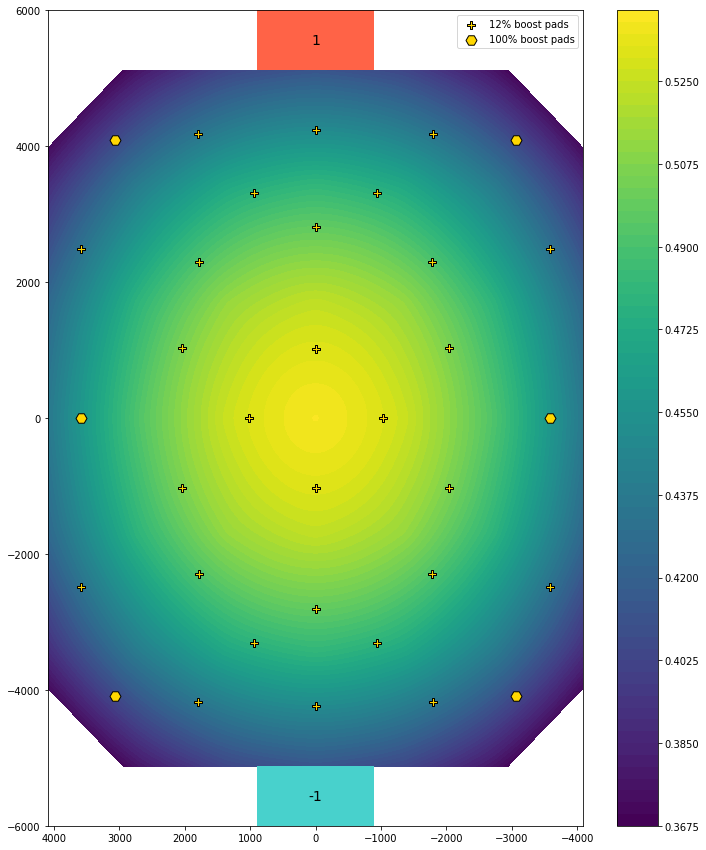

In [65]:
plotting.arena_contour(cust_liu_dist_player2ball__mean_zs)

### Ball to goal distance

In [66]:
cust_liu_dist_ball2goal_zs = custom.signed_liu_dist_ball2goal(arena_positions, dispersion=1, density=1)

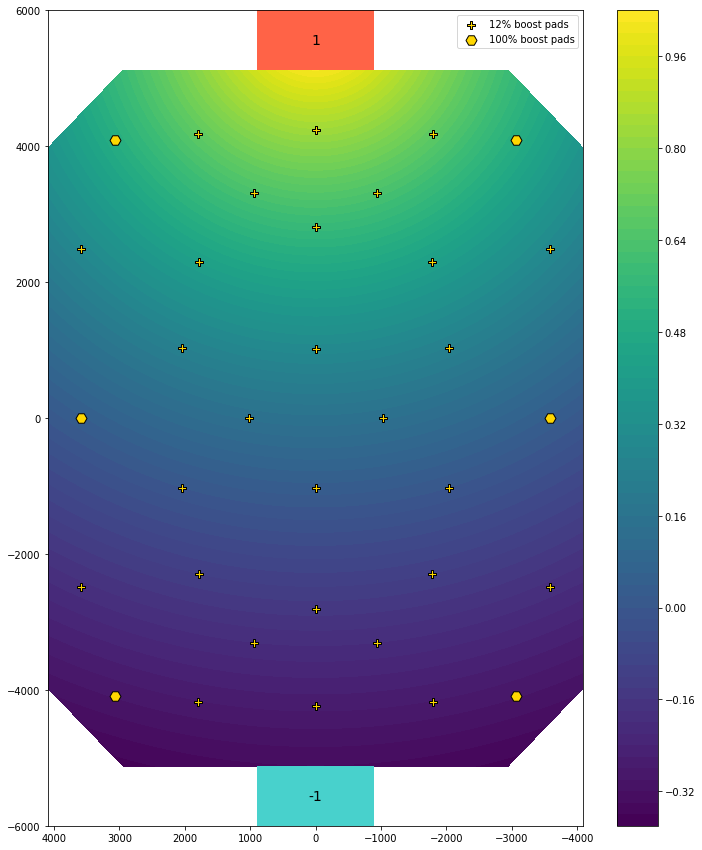

In [67]:
plotting.arena_contour(cust_liu_dist_ball2goal_zs)

In [68]:
cust_liu_dist_ball2goal_zs = custom.signed_liu_dist_ball2goal(arena_positions, dispersion=1.2, density=1)

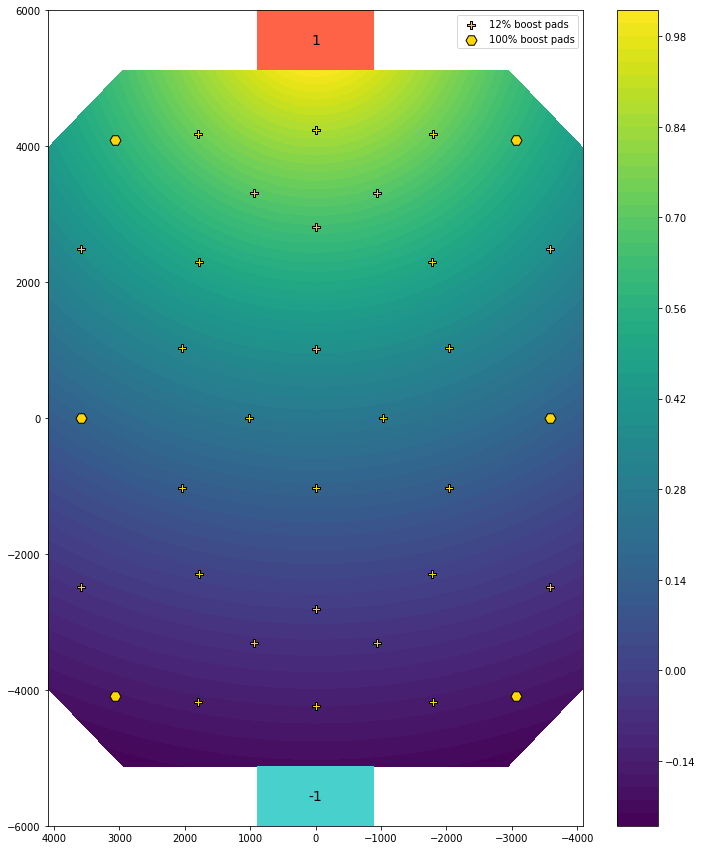

In [69]:
plotting.arena_contour(cust_liu_dist_ball2goal_zs)

In [70]:
cust_liu_dist_ball2goal_zs = custom.signed_liu_dist_ball2goal(arena_positions, dispersion=0.9, density=1.3)

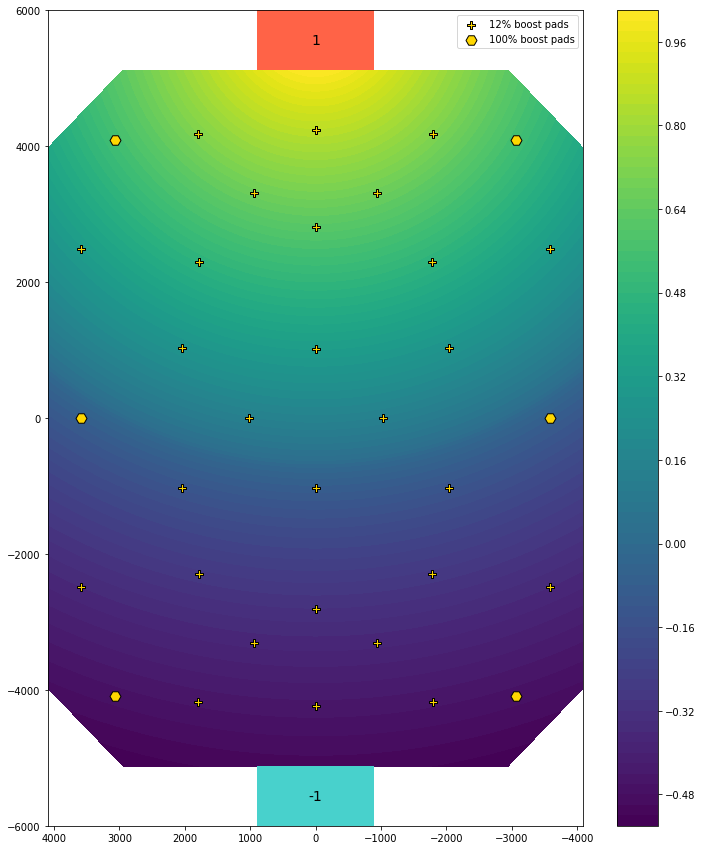

In [71]:
plotting.arena_contour(cust_liu_dist_ball2goal_zs)

## Additional

### Ball to goal distance orange to blue difference

Inspired by the Necto reward

In [72]:
liu_dist_ball2goal_difference_zs = (common.liu_dist_ball2goal(arena_positions) -
                                    common.liu_dist_ball2goal(arena_positions, True))

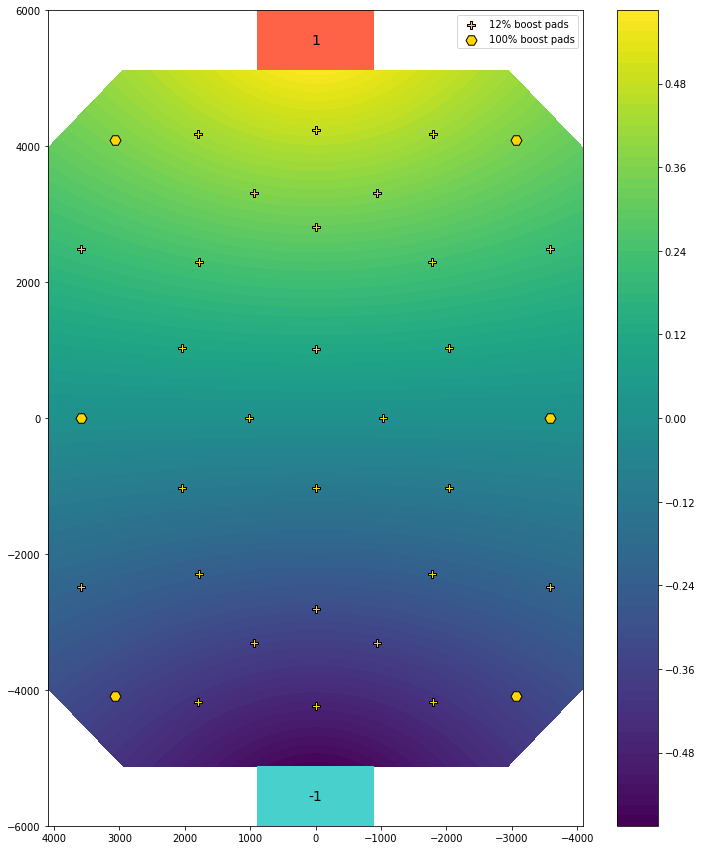

In [73]:
plotting.arena_contour(liu_dist_ball2goal_difference_zs)

Additional reward thoughts and ideas:
- What is a good potential function?

Inspired by Necto:
- Touch ball with acceleration, toward goal preferably?
- Reward ball goal speed? Is it possible with ball to goal velocity?
- Opponent punish weight in distributed team spirit reward?
- How much does dribbling reward? We assume a semi-continuous touch ball reward at ball height axis z=150.